# You can run sapphire interactively in 3 simple steps:
1. import sapphire
2. define python dictionary of input parameters (see docs and below) 
3. sapphire.run(parameters) 

Soon there will be a way to run from the command line "python -m sapphire parameters.json" 
(useful if you want to run many parameter variations simultaneously on different nodes) 

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from astropy.table import Table
from astropy.cosmology import Planck15

In [3]:
# read in the pickle which contains a list of dictionaries 
with open('lucas_variations.pkl','rb') as f:
    dat = pickle.load(f)

In [4]:
# you can see that this is a list of dicts 
# every dict gives the values of the free parameters (all other parameters were fixed)
# I only varied 7 parameters at 3 different values each since this was expensive (until I get the JAX version working for populations)
# so there are 3**7 = 2187 realizations
# every dict also gives 2 arrays: the arrays of z=0 Mvir (halo mass) and z=0 Mstar -- these can be used to compare to the Behroozi+19 relation (see below)
dat[:3]

[{'etaM_A': 1.0,
  'etaM_alpha0': -0.5,
  'tdep_A': 3.0,
  'tdep_alpha0': -3.0,
  'tdep_beta': -0.7,
  'etaE_A': 0.1,
  'etaE_alpha0': -0.5,
  'z0_Mvir': array([1.68452297e+10, 1.70928909e+10, 1.63634428e+10, 1.64137316e+10,
         1.56979711e+10, 1.52374067e+10, 1.49757350e+10, 1.54624206e+10,
         1.84334960e+10, 2.52440473e+10, 2.21650916e+10, 1.68883716e+10,
         1.92094379e+10, 2.46717143e+10, 2.00920530e+10, 1.92655769e+10,
         2.23955759e+10, 1.92213558e+10, 1.96427727e+10, 3.53315542e+10,
         4.45009232e+10, 3.84570169e+10, 3.16490778e+10, 3.03469874e+10,
         2.62825159e+10, 3.46701943e+10, 3.10341907e+10, 3.70630046e+10,
         5.92274693e+10, 5.71138933e+10, 5.79499653e+10, 4.78123902e+10,
         5.79802038e+10, 5.06513500e+10, 3.95973735e+10, 6.74961758e+10,
         4.89730725e+10, 6.60533079e+10, 9.04238278e+10, 7.39497769e+10,
         6.86702889e+10, 7.59880815e+10, 7.08181613e+10, 7.64558576e+10,
         1.39016309e+11, 1.40680601e+11, 1.17

Text(0, 0.5, '# realizations')

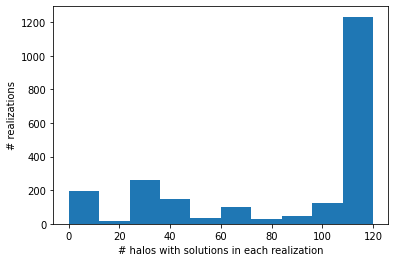

In [5]:
# there should be 120 halos total per realization (10 for each of Behroozi+19's 12 Mvir bins) 
# however there are many unphysical parameter combos since we uniformly sampled in each parameter dimension
# this means that in these unphysical parameter combos, only a fraction of the halos may have had solutions
# we can use the length of the z0_Mstar or z0_Mvir arrays to see how many halos were solved
Nhalos = np.array([len(d['z0_Mstar']) for d in dat])

_ = plt.hist(Nhalos)

plt.xlabel('# halos with solutions in each realization')
plt.ylabel('# realizations')

(array([   0.,    0.,    0.,    0.,    0., 2187.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

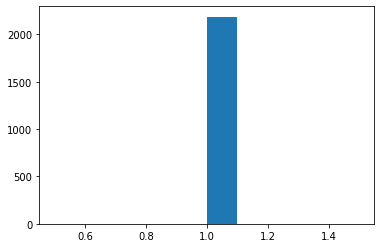

In [6]:
plt.hist(np.array([d["etaM_A"] for d in dat]))

In [7]:
dat[3]["z0_Mstar"].shape

(60,)

In [9]:
# only ~1300 of the 2187 realizations have > 100 halos with solutions
# about 200 realizations have <10 halos across all mass bins
# about 100 realizations have ZERO halos 
# unsure if these realizations should be discarded, or downweighted, or what 
# NOTE: I will need to do some tests to see if increasing the ODE solver tolerance helps this
len(Nhalos[Nhalos>100]), len(Nhalos[Nhalos<10]), len(Nhalos[Nhalos==0])

1337

In [10]:
# anyway, for a given realization (dict in dat), you can grab the dict from dat 
# and then reconstruct the stellar-to-halo mass relation to compare to Behroozi+19 as follows 

# this 15th realization has nearly the full sample of 120 halos so it's a good realization to test on
d = dat[15]
len(d['z0_Mvir']) 


117

In [12]:
# read in Behroozi+19 UniverseMachine DR1 Median SMHM relation at z=0  
# and discard bins below logmvir<10.5 due to Bolshoi-Planck resolution limit (not sure why he included these)
tum = Table.read('/mnt/ceph/users/vpandya/sapphire/demo/smhm_a1.002312.dat',format='ascii')
tum = tum[(tum['HM(0)']>=10.0) & (tum['HM(0)']<=12.4)]


Text(0, 0.5, '$\\log_{10}M_{\\rm star}/M_{\\rm vir}$ (z=0)')

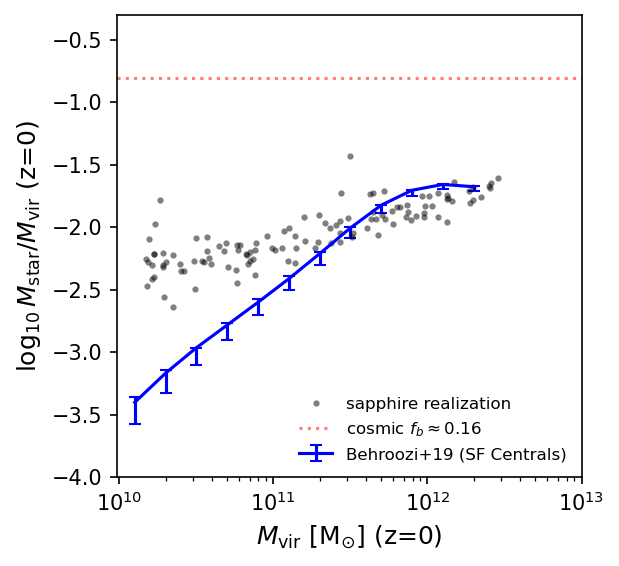

In [15]:
# compare SMHM relation from Behroozi vs this realization of our model

fig, ax = plt.subplots(1,figsize=(4,4),dpi=150)

# plot Behroozi+19 relation including only central SF galaxies/halos
ax.errorbar(10**tum['HM(0)'],tum['Med_Cen_SF(7)'],yerr=[np.abs(tum['Err-(9)']),np.abs(tum['Err+(8)'])],fmt='b-',capsize=3,label='Behroozi+19 (SF Centrals)')

ax.plot(d['z0_Mvir'],np.log10(d['z0_Mstar']/d['z0_Mvir']),'k.',alpha=0.5,mec='none',label='sapphire realization')

ax.set_xscale('log')
ax.set_xlim(None,1e13)
ax.set_ylim(-4,-0.3)

ax.axhline(np.log10(Planck15.Ob0/Planck15.Om0),color='r',ls=':',alpha=0.5,label=r'cosmic $f_b\approx0.16$')

ax.legend(loc='lower right',fontsize=8,fancybox=True,framealpha=0)

ax.set_xlabel(r'$M_{\rm vir}$ [M$_{\odot}$] (z=0)',fontsize=12)
ax.set_ylabel(r'$\log_{10}M_{\rm star}/M_{\rm vir}$ (z=0)',fontsize=12)


In [16]:
tum

HM(0),Med_All(1),Err+(2),Err-(3),Med_Cen(4),Err+(5),Err-(6),Med_Cen_SF(7),Err+(8),Err-(9),Med_Cen_Q(10),Err+(11),Err-(12),Med_Sat(13),Err+(14),Err-(15),Med_SF(16),Err+(17),Err-(18),Med_Q(19),Err+(20),Err-(21),True_Med_All(22),Err+(23),Err-(24),True_Cen(25),Err+(26),Err-(27),True_Cen_SF(28),Err+(29),Err-(30),True_Cen_Q(31),Err+(32),Err-(33),True_Sat(34),Err+(35),Err-(36),True_SF(37),Err+(38),Err-(39),True_Q(40),Err+(41),Err-(42)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10.1,-3.374289,0.04297,0.170815,-3.401626,0.043973,0.173078,-3.402734,0.044818,0.171419,-3.223874,0.167977,0.132328,-3.208457,0.044869,0.147945,-3.376028,0.043244,0.169588,-3.165777,0.186321,0.132243,-3.379339,0.036633,0.208364,-3.40636,0.034574,0.212059,-3.407479,0.035323,0.212327,-3.232202,0.172403,0.148271,-3.213817,0.039357,0.189278,-3.381106,0.03692,0.210836,-3.173654,0.199376,0.131137
10.3,-3.13622,0.023013,0.152712,-3.167731,0.021709,0.156777,-3.169031,0.021883,0.155809,-3.038357,0.108789,0.110581,-2.9861,0.021593,0.13448,-3.13876,0.022353,0.153695,-2.96474,0.18757,0.111049,-3.141433,0.018872,0.193938,-3.172791,0.016476,0.200985,-3.174077,0.01675,0.19977,-3.045682,0.112787,0.144055,-2.991092,0.020428,0.179039,-3.143972,0.020244,0.192003,-2.972538,0.185967,0.103469
10.5,-2.930211,0.0,0.136239,-2.964034,-0.002026,0.141237,-2.965317,-0.001994,0.14101,-2.881353,0.09183,0.092084,-2.785308,0.001656,0.114646,-2.933907,0.0,0.135299,-2.775238,0.211621,0.101775,-2.934972,0.007893,0.18074,-2.968697,0.007662,0.188677,-2.969951,0.008138,0.189019,-2.890918,0.089573,0.118542,-2.790143,0.013724,0.158838,-2.938714,0.007076,0.182201,-2.780872,0.221182,0.093885
10.7,-2.740482,-0.014568,0.110318,-2.782,-0.017277,0.119456,-2.783359,-0.016172,0.119637,-2.72226,0.084219,0.08736,-2.577202,-0.003634,0.082211,-2.746782,-0.015158,0.110933,-2.580641,0.173739,0.074911,-2.745738,0.001528,0.160136,-2.787058,0.00129,0.173833,-2.788343,0.000441,0.174017,-2.731781,0.084216,0.109045,-2.58215,0.008515,0.135298,-2.751981,0.002294,0.163834,-2.587359,0.170833,0.082765
10.9,-2.547818,-0.016654,0.087788,-2.600154,-0.022625,0.104838,-2.601339,-0.023399,0.104963,-2.563603,0.062664,0.069959,-2.374736,-0.002317,0.06275,-2.556839,-0.015781,0.092476,-2.413911,0.108239,0.061362,-2.553756,0.004581,0.145532,-2.604921,0.0,0.16563,-2.606167,-0.000257,0.166548,-2.569822,0.070341,0.105021,-2.379289,0.017961,0.123205,-2.562726,0.00185,0.148489,-2.419843,0.109829,0.072567
11.1,-2.359215,-0.016454,0.077139,-2.411489,-0.022251,0.091368,-2.412814,-0.02281,0.091789,-2.389235,0.047047,0.051067,-2.202583,-0.004511,0.064251,-2.369972,-0.019325,0.081185,-2.255583,0.078909,0.04752,-2.364676,0.01624,0.143108,-2.416704,0.008446,0.158575,-2.418017,0.008158,0.15895,-2.393836,0.064923,0.094979,-2.208204,0.019354,0.128918,-2.375455,0.012172,0.145066,-2.262843,0.083295,0.073553
11.3,-2.162537,-0.009,0.070403,-2.21107,-0.012474,0.083703,-2.212061,-0.01291,0.086461,-2.200317,0.031838,0.043107,-2.015207,-0.002218,0.060488,-2.174855,-0.012527,0.076394,-2.083537,0.057466,0.029125,-2.16806,0.023879,0.132847,-2.215605,0.018628,0.149548,-2.216383,0.015261,0.151978,-2.20626,0.044162,0.100746,-2.020394,0.024236,0.12653,-2.180113,0.019599,0.140126,-2.088178,0.069639,0.082476
11.5,-1.958506,-0.002649,0.060672,-2.00395,-0.003474,0.074054,-2.005622,-0.003685,0.078556,-1.993713,0.027965,0.039741,-1.820629,0.0,0.05661,-1.973225,-0.004201,0.072021,-1.897685,0.038302,0.025077,-1.963827,0.029177,0.124058,-2.009082,0.025588,0.136282,-2.01048,0.025552,0.139515,-2.000796,0.039832,0.106282,-1.824956,0.023172,0.123739,-1.978193,0.025296,0.1308,-1.904091,0.052083,0.08472
11.7,-1.784507,0.000216,0.046219,-1.822329,-0.000243,0.05737,-1.823466,-0.002959,0.0

In [24]:
# create the halo mass bin edges from Behroozi table -- it's +/- 0.1 dex around each bin center 
# this will be a list of tuples (Mmin,Mmax)

bin_edges = np.arange(10.0,12.4,0.2) # note the masses are log10 mvir
print(bin_edges)

bin_defs = [(bin_edges[i],bin_edges[i+1]) for i in range(len(bin_edges)-1)]

bin_defs

[10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4]


[(10.0, 10.2),
 (10.2, 10.399999999999999),
 (10.399999999999999, 10.599999999999998),
 (10.599999999999998, 10.799999999999997),
 (10.799999999999997, 10.999999999999996),
 (10.999999999999996, 11.199999999999996),
 (11.199999999999996, 11.399999999999995),
 (11.399999999999995, 11.599999999999994),
 (11.599999999999994, 11.799999999999994),
 (11.799999999999994, 11.999999999999993),
 (11.999999999999993, 12.199999999999992),
 (12.199999999999992, 12.399999999999991)]

In [25]:
""" 
Suppose you wanted to compute the goodness of fit 
One way is to first bin up the SAM halos in the same mass bins as Behroozi and then compute the median SMHM of all halos in each mass bin

NOTE: I am not sure this is the best way to compare the model to the data
It is probably better to compute the deviation of each individual halo from the Behroozi+19 median for the mass bin it belongs to
But for that, I need to fix a minor bug with the interpolator inside sapphire for df_results['Mvir'], so maybe use this median approach for now ...
This current median relation approach forces the two bin definitions to align 
"""

def median_smhm(d,Mmin,Mmax):
    """ 
    Filters input dict to only consider halos with z=0 Mvir between Mmin and Mmax
    Then returns median SMHM ratio for those halos
    """
    
    z0_Mvir = d['z0_Mvir']
    z0_Mstar = d['z0_Mstar']
    
    Mvir_bin = z0_Mvir[(z0_Mvir > 10**Mmin) & (z0_Mvir < 10**Mmax)]
    Mstar_bin = z0_Mstar[(z0_Mvir > 10**Mmin) & (z0_Mvir < 10**Mmax)]    
    
    return np.median(Mstar_bin / Mvir_bin)

# we will store median smhm of predicted halos in the realization dat[15] above
median_smhm_d15 = np.array([])

for Mmin,Mmax in bin_defs: # our Mmin,Mmax bin edges for downsampling the # of halos was the same as the Behroozi bin definitions

    ### filter dataframe for both models to only contain halos that fall within current z=0 Mvir bin

    median_smhm_d15 = np.append(median_smhm_d15, median_smhm(d,Mmin,Mmax))
    

Text(0, 0.5, '$\\log_{10}M_{\\rm star}/M_{\\rm vir}$ (z=0)')

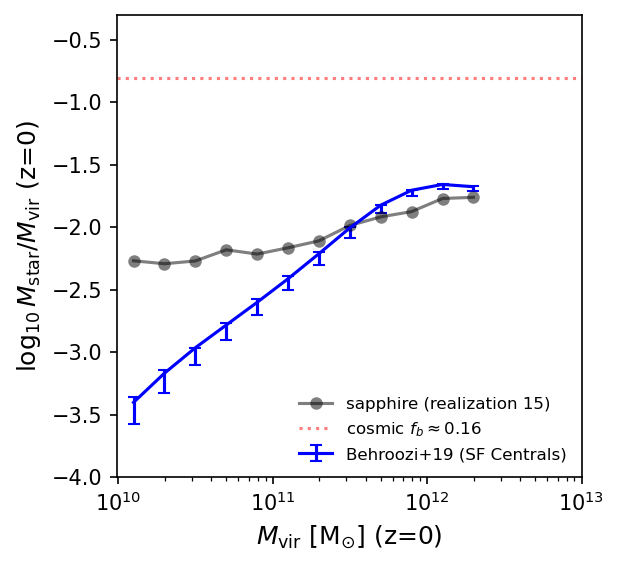

In [26]:
### finally overplot the 2 median relations assuming the same bin centers as Behroozi+19 

fig, ax = plt.subplots(1,figsize=(4,4),dpi=150)

# plot Behroozi+19 relation including only central SF galaxies/halos
ax.errorbar(10**tum['HM(0)'],tum['Med_Cen_SF(7)'],yerr=[np.abs(tum['Err-(9)']),np.abs(tum['Err+(8)'])],fmt='b-',capsize=3,label='Behroozi+19 (SF Centrals)')

ax.plot(10**tum['HM(0)'],np.log10(median_smhm_d15),'ko-',alpha=0.5,mec='none',label='sapphire (realization 15)')

ax.set_xscale('log')
ax.set_xlim(None,1e13)
ax.set_ylim(-4,-0.3)

ax.axhline(np.log10(Planck15.Ob0/Planck15.Om0),color='r',ls=':',alpha=0.5,label=r'cosmic $f_b\approx0.16$')

ax.legend(loc='lower right',fontsize=8,fancybox=True,framealpha=0)

ax.set_xlabel(r'$M_{\rm vir}$ [M$_{\odot}$] (z=0)',fontsize=12)
ax.set_ylabel(r'$\log_{10}M_{\rm star}/M_{\rm vir}$ (z=0)',fontsize=12)
